In [1]:
from scipy.io import loadmat
from scipy.linalg import eigh, inv
import numpy as np
import matplotlib.pyplot as plt

## Load graph dataset

In [2]:
# load gene network
gene_network = loadmat('data/genetics/geneNetwork_rawPCNCI.mat')
A = gene_network['geneNetwork_rawPCNCI'].astype(np.int32)

In [3]:
# load signal dataset 
signals = loadmat('data/genetics/signal_mutation.mat')
X = signals['signal_mutation'].T

# load phenotypes (labels)
phenotypes = loadmat('data/genetics/histology_subtype.mat')
y = phenotypes['histology_subtype']

'Shapes: A: {}, X: {}, y: {}'.format(A.shape, X.shape, y.shape)

'Shapes: A: (2458, 2458), X: (2458, 240), y: (240, 1)'

## a) Distinguishing power

In [4]:
# Compute Laplacian as shift matrix
D = np.diag(A.sum(axis=1))
L = D - A
S = L

# Diagonalize S (reorder evals from largest to smallest)
w, V = [x.real for x in eigh(S)] # imag parts are float errors

eval_idxs = w.argsort()[::-1]
w = w[eval_idxs]
V = V[:, eval_idxs]
Vinv = inv(V)
W = np.diag(w)

# verify diagonalization (should be near 0, due to float errors)
print('L1 norm between L and V @ W @ V.T: {}'.format((L - np.dot(np.dot(V, W), V.T)).sum()))

L1 norm between L and V @ W @ V.T: 1.3088795888749849e-11


In [12]:
X_gft = V.T @ X # x_gft[i, j] is coefficient of ith freq for jth sample

# verify GFT is valid (should be near 0)
print('Error after V @ V.T @ X: {}'.format(np.linalg.norm(X - (V @ X_gft))))

Error after V @ V.T @ X: 2.452676171569576e-13


In [13]:
# label masks
mask_1 = (y == 1).astype(int).reshape(y.shape[0])
mask_2 = (y == 2).astype(int).reshape(y.shape[0])

# mean filter for each label
mean_1 = mask_1 / mask_1.sum()
mean_2 = mask_2 / mask_2.sum()

# L1 norm of each frequency
k_L1 = np.linalg.norm(X_gft, ord=1, axis=1)

In [7]:
DP = np.absolute((X_gft @ mean_1) - (X_gft @ mean_2)) / k_L1
DP = DP.reshape(DP.shape[0])

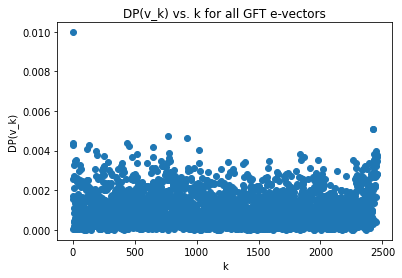

In [8]:
plt.scatter(range(DP.shape[0]), DP)
plt.xlabel('k')
plt.ylabel('DP(v_k)')
plt.title('DP(v_k) vs. k for all GFT e-vectors');

## b) kNN classifier

In [48]:
def knn(X, y, k_all):
    """
    Computes the leave-one-out CV accuracy using kNN, for multiple values of k.
    """
    # compute pairwise distances between column samples
    dists = np.zeros((X.shape[1], X.shape[1])) # dists[i][j] = distance between samples i and j

    for i in range(X.shape[1]):
        for j in range(i+1, X.shape[1]):
            dist = np.linalg.norm(X[:, i] - X[:, j])
            dists[i, j] = dist
            dists[j, i] = dist

    # neighbors of each sample, ordered by increasing distance
    nns = dists.argsort(axis=1)[:, 1:]

    # classes of nearest neighbors
    y_nns = y[nns][:, :, 0]

    k_all = [3, 5, 7]

    for k in k_all:
        # get most common class from each sample's kNNs
        preds = y_nns[:, :k].mean(axis=1) >= 1.5 # True = class 2, False = class 1
        print('\tAccuracy for k = {}: {}'.format(k, (preds == (y - 1)).mean()))


In [49]:
knn(X, y, [3, 5, 7])

	Accuracy for k = 3: 0.7084722222222222
	Accuracy for k = 5: 0.7216666666666667
	Accuracy for k = 7: 0.7190277777777778


## c) Filtering almost all frequencies

In [50]:
# order frequencies by DP
k_idxs = np.argsort(DP)[::-1]
print('k = {} maximizes distinguishing power'.format(k_idxs[0]))

k = 2 maximizes distinguishing power


In [73]:
xgftf = np.zeros(X_gft.shape)
xgftf[2, :] = X_gft[2, :]

xf = V @ xgftf
dists = np.zeros([xf.shape[1]] * 2)
for i in range(len(dists)):
    for j in range(i+1, len(dists)):
        dists[i, j] = np.linalg.norm(xf[:, i] - xf[:, j])

dists = dists +

idxs = dists.argsort(axis=1)[1:, :]
dists

array([[0.00000000e+00, 1.02877980e+00, 1.05344245e+00, ...,
        6.38907007e-03, 7.12540266e-03, 1.32034854e-03],
       [1.02877980e+00, 0.00000000e+00, 2.46626476e-02, ...,
        1.02239073e+00, 1.02165440e+00, 1.02745946e+00],
       [1.05344245e+00, 2.46626476e-02, 0.00000000e+00, ...,
        1.04705338e+00, 1.04631705e+00, 1.05212210e+00],
       ...,
       [6.38907007e-03, 1.02239073e+00, 1.04705338e+00, ...,
        0.00000000e+00, 7.36332588e-04, 5.06872153e-03],
       [7.12540266e-03, 1.02165440e+00, 1.04631705e+00, ...,
        7.36332588e-04, 0.00000000e+00, 5.80505412e-03],
       [1.32034854e-03, 1.02745946e+00, 1.05212210e+00, ...,
        5.06872153e-03, 5.80505412e-03, 0.00000000e+00]])

In [51]:
def filter_gft(X_gft, k_idxs, keep_ratio):
    """
    Filters the GFT of a signal matrix to preserve only the top keep_ratio frequencies
        as ordered by k_idxs
    """
    n_keep = int(len(k_idxs) * keep_ratio)
    k_top = k_idxs[:n_keep]
    print('\tKept {} frequencies'.format(n_keep))
    
    # select frequencies to preserve
    X_gft_f = np.zeros(X_gft.shape)
    X_gft_f[k_top, :] = X_gft[k_top, :]

    return X_gft_f

In [52]:
def filtered_knn(X_gft, y, k_idxs, keep_ratio, n_nbrs_all):
    """
    Filters the GFT of a signal matrix, then evaluates classification accuracy using kNN
    """

    # preserve only values at the top frequency
    X_gft_f = filter_gft(X_gft, k_idxs, keep_ratio)
    
    # take iGFT of filtered signal
    X_f = V @ X_gft_f

    # kNN
    knn(X_f.T, y, n_nbrs_all)

In [53]:
# try kNN, keeping only the top frequency
filtered_knn(X_gft, y, k_idxs, 1 / len(k_idxs), [3, 5, 7])

	Kept 1 frequencies


IndexError: index 1045 is out of bounds for axis 0 with size 240

In [ ]:
# try kNN, with other values of p
p_all = [0.75, 0.8, 0.85, 0.9, 0.95]

for p in p_all:
    print('With top {} of frequencies:'.format(1 - p))
    filtered_knn(X_gft, y, k_idxs, 1 - p, [3, 5, 7])

With top 0.25 of frequencies:
	Kept 614 frequencies
	Accuracy for k = 3: 0.6979166666666666
	Accuracy for k = 5: 0.7005555555555556
	Accuracy for k = 7: 0.6952777777777778
With top 0.19999999999999996 of frequencies:
	Kept 491 frequencies
	Accuracy for k = 3: 0.6979166666666666
	Accuracy for k = 5: 0.6952777777777778
	Accuracy for k = 7: 0.7005555555555556
With top 0.15000000000000002 of frequencies:
	Kept 368 frequencies
	Accuracy for k = 3: 0.6926388888888889
	Accuracy for k = 5: 0.6926388888888889
	Accuracy for k = 7: 0.6926388888888889
With top 0.09999999999999998 of frequencies:
	Kept 245 frequencies
	Accuracy for k = 3: 0.6847222222222222
	Accuracy for k = 5: 0.6847222222222222
	Accuracy for k = 7: 0.6847222222222222
With top 0.050000000000000044 of frequencies:
	Kept 122 frequencies
	Accuracy for k = 3: 0.6794444444444444
	Accuracy for k = 5: 0.6847222222222222
	Accuracy for k = 7: 0.6847222222222222
